## Some plots for the Dynamic Foraging White Book

Han Hou 02/2025

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from aind_analysis_arch_result_access.han_pipeline import get_session_table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Get the master session table

In [3]:
df = get_session_table()
len(df)

6800

## Session count grouped by curriculum over time

In [4]:
df_curriculum = df[['subject_id', 'session_date', 'session', 'curriculum_name', 'curriculum_version', 'current_stage_actual']]

In [5]:
def plot_session_counts_over_time(
    df,
    time_bin="D",
    bar_width=0.8,
    group_by="curriculum_name",
    group_rename=None,
    group_custom_order=None,
    group_custom_color=None,
    ax=None,
):
    """Plot the number of sessions over time, grouped by a specified column.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the session data. Must contain 'session_date' and the column specified by group_by.
    time_bin : str, optional
        Resampling frequency for the x-axis. See pandas resample for options, by default "D"
    bar_width : float, optional
        Width of the bars in the bar chart, by default 0.8
    group_by : str, optional
        Column name to group by. Must be present in the DataFrame, by default "curriculum_name"
    group_rename : _type_, optional
        rename the groups of the unique values of the group_by column, by default None
    group_custom_order : _type_, optional
        custom order of the groups of the unique values of the group_by column, by default None
    group_custom_color : _type_, optional
        custom color of the groups of the unique values of the group_by column, by default None
    ax : _type_, optional
        _description_, by default None

    Returns
    -------
    _type_
        _description_
    """
    # Count number of sessions per day per type
    session_counts = (
        df.groupby([pd.Grouper(key="session_date", freq=time_bin), group_by])
        .size()
        .unstack(fill_value=0)
    )
    if group_rename is not None:
        session_counts = session_counts.rename(columns=group_rename)
    if group_custom_order is not None:
        session_counts = session_counts[group_custom_order]

    # Plot stacked bar chart
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    session_counts.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        width=bar_width,
        **({} if group_custom_color is None else {"color": group_custom_color}),
    )
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of sessions")
    ax.legend(title=group_by)

    # Format x-axis to show only year and month
    ax.set_xticks([])  # Hide all default x-ticks
    ax.set_xticks(
        range(len(session_counts),0, -max(1, len(session_counts) // 10))
    )  # Set sparse ticks
    ax.set_xticklabels(
        session_counts.index[:: -max(1, len(session_counts) // 10)].strftime("%Y-%m"),
        rotation=45,
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Rotate x axix ticks
    ax.tick_params(axis="x", rotation=45)
    return ax

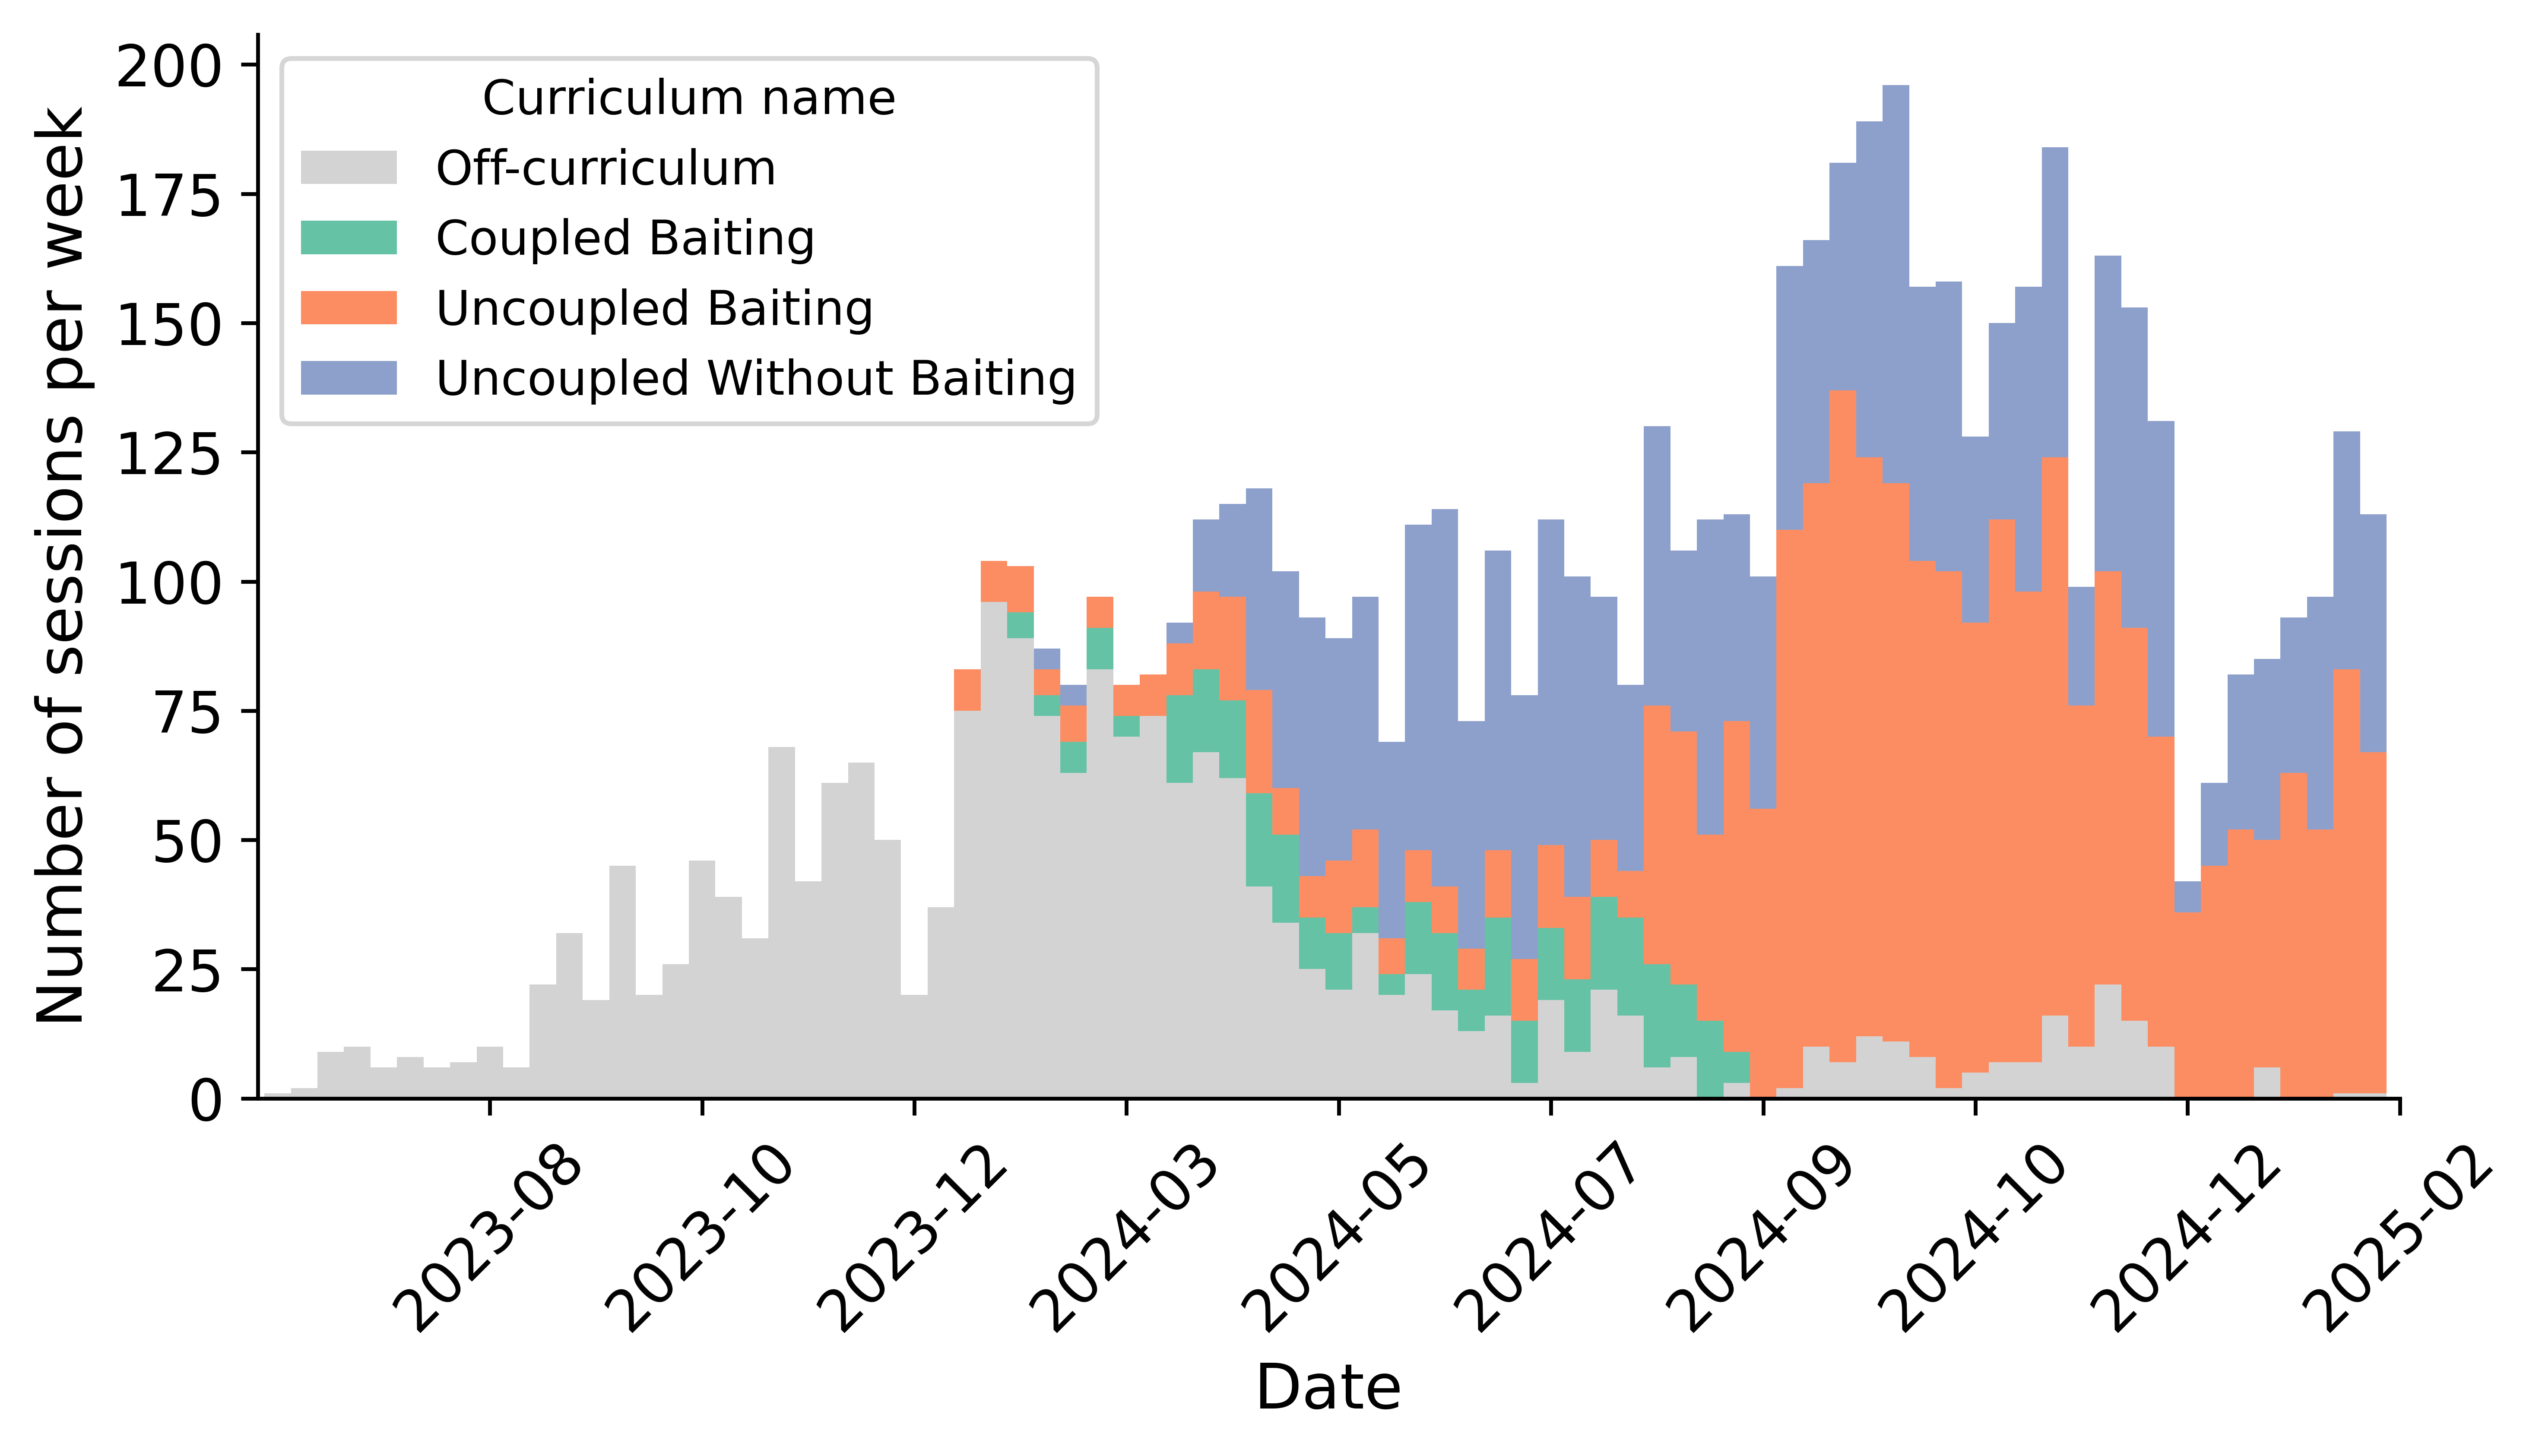

In [6]:
import matplotlib
import matplotlib.colors as mcolors
plt.rcParams.update({'font.size': 12})

# Get colors from the "Set2" colormap
colormap = matplotlib.colormaps["Set2"]

# Display the plot
fig, ax = plt.subplots(figsize=(8, 4), dpi=800)
ax = plot_session_counts_over_time(
    df_curriculum,
    time_bin="W",
    bar_width=1,
    group_rename={
        "Coupled Baiting": "Coupled Baiting",
        "Uncoupled Baiting": "Uncoupled Baiting",
        "Uncoupled Without Baiting": "Uncoupled Without Baiting",
        "None": "Off-curriculum",
    },
    group_custom_order=["Off-curriculum", "Coupled Baiting", "Uncoupled Baiting", "Uncoupled Without Baiting"],
    group_custom_color=["lightgray"] + [colormap(i) for i in range(3)],
    ax=ax,
)

# set axis title font size
ax.set_xlabel("Date", fontsize=13)
ax.set_ylabel("Number of sessions per week", fontsize=13)

# set legend title font size
ax.legend(title="Curriculum name", title_fontsize=10, fontsize=10)

# save svg
fig.savefig("session_counts_by_curriculum_name_over_time.svg", bbox_inches="tight")


## Autotrain trajectory and distribution

In [33]:
df_curriculum_on_only = df_curriculum.query('curriculum_name != "None" and curriculum_version != "0.1"').copy()
len(df_curriculum_on_only)

4786

### Stage progression trajectory

In [83]:
stage_order = [
    "STAGE_1_WARMUP",
    "STAGE_1",
    "STAGE_2",
    "STAGE_3",
    "STAGE_4",
    "STAGE_FINAL",
    "GRADUATED",
]

def get_stage_color_mapper(stage_list):
    # Mapping stages to colors from red to green, return rgb values
    # Interpolate between red and green using the number of stages
    cmap = matplotlib.colormaps['RdYlGn']
    stage_color_mapper = {
        stage: matplotlib.colors.rgb2hex(
            cmap(i / (len(stage_list) - 1))) 
        for i, stage in enumerate(stage_list)
    }
    return stage_color_mapper

stage_color_mapper = get_stage_color_mapper(stage_order)

In [35]:
def plot_stage_progression(df, subject_ids_highlight=[], ax=None, color='black'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 2), dpi=500)

    all_mice = df["subject_id"].unique()
    
    # put highlight mice at the last
    subject_ids = [
        subject_id for subject_id in all_mice if subject_id not in subject_ids_highlight
    ] + subject_ids_highlight

    for subject_id in subject_ids:        
        subject_df = df.query("subject_id == @subject_id")
        subject_df = subject_df.sort_values(by="session_date")

        # add a random small jitter
        ax.plot(
            subject_df["session"] + np.random.normal(0, 0.1, len(subject_df)),
            subject_df["current_stage_y"] + np.random.normal(0, 0.1, len(subject_df)),
            label=subject_id,
            alpha=0.5 if subject_id not in subject_ids_highlight else 1,
            color=color if subject_id not in subject_ids_highlight else "red",
            linewidth=0.2 if subject_id not in subject_ids_highlight else 1,
        )

    ax.set(
        xlabel="Session",
        yticks=range(len(df.current_stage_actual.unique())),
        yticklabels=[stage for stage in stage_order if stage in df.current_stage_actual.unique()],
        ylim=(-0.5, 6.5),
    )
    return ax

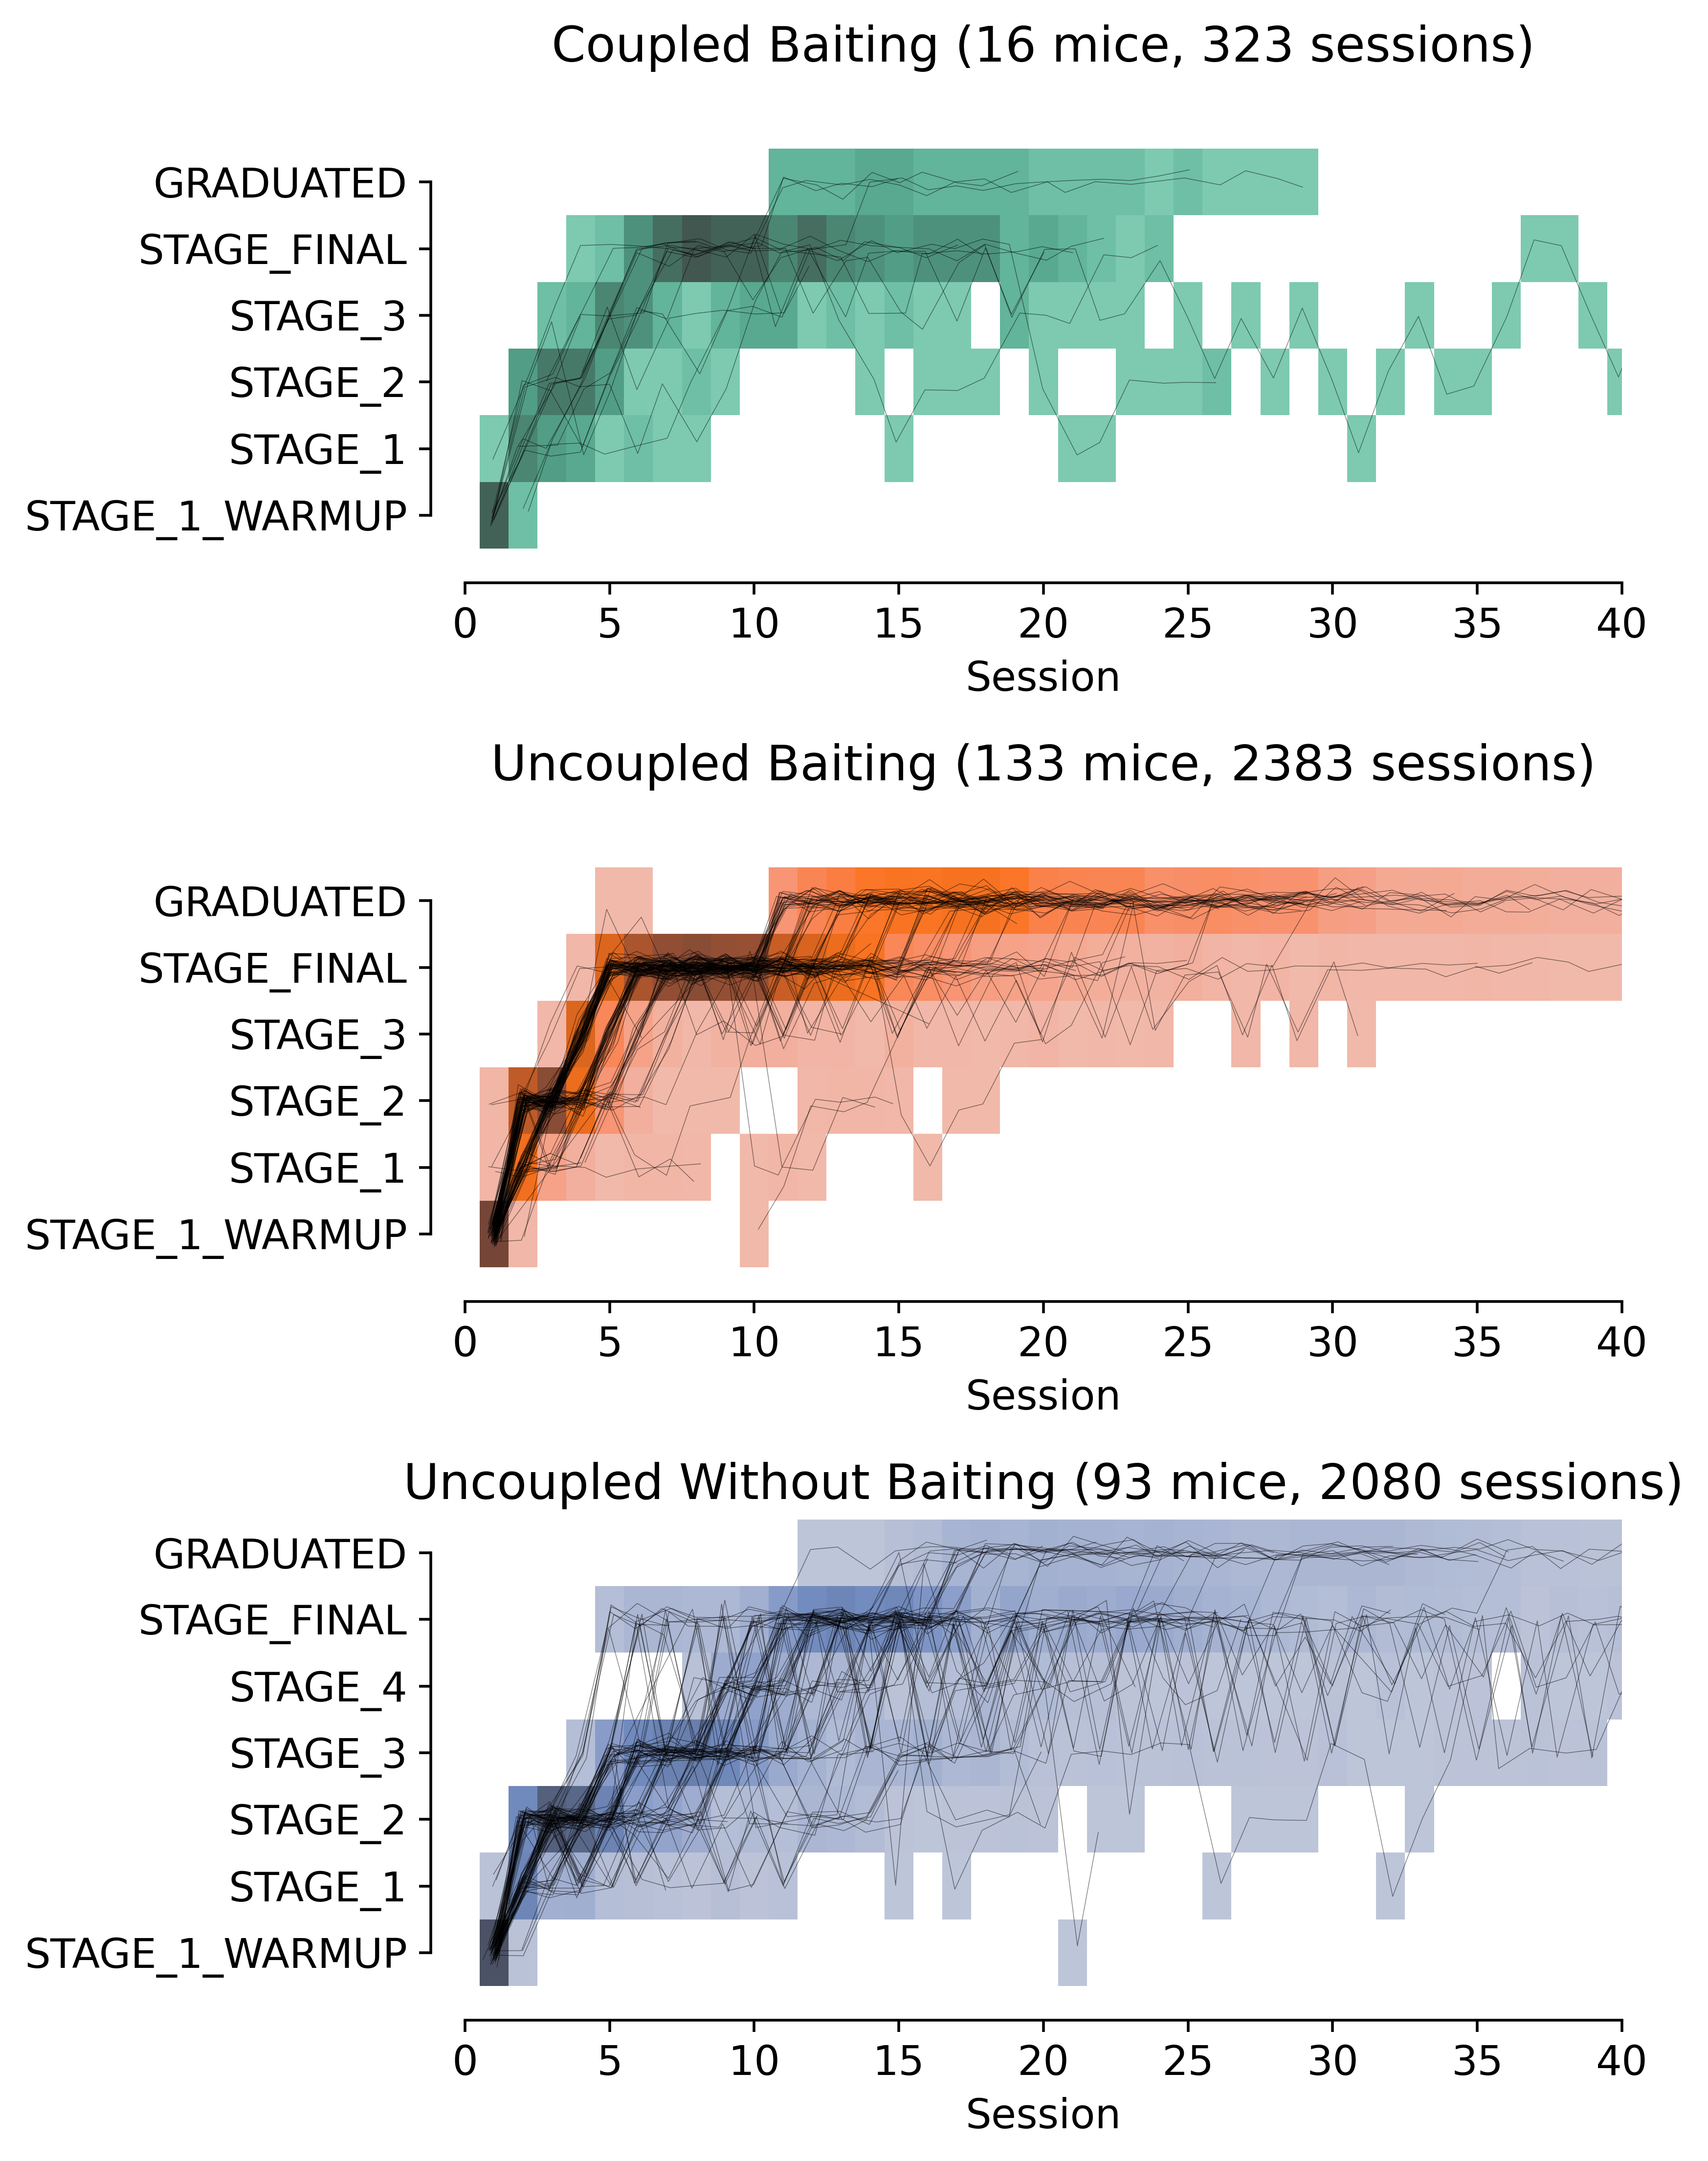

In [94]:
curriculum_name_order = ["Coupled Baiting", "Uncoupled Baiting", "Uncoupled Without Baiting"]
colormap = matplotlib.colormaps["Set2"]

fig, ax = plt.subplots(3, 1, figsize=(7, 9), dpi=500)

for i, curriculum in enumerate(curriculum_name_order):
    df_this = df_curriculum_on_only.query("curriculum_name == @curriculum").copy()

    # Add current_stage_y for each curriculum
    all_unique_stages = [stage for stage in stage_order if stage in df_this["current_stage_actual"].unique()]
    df_this["current_stage_y"] = df_this["current_stage_actual"].map(lambda x: all_unique_stages.index(x))

    # -- plot the stage progression for each curriculum --
    plot_stage_progression(
        df_this,
        subject_ids_highlight=[],
        ax=ax[i],
    )

    # -- density plot for each curriculum --
    sns.histplot(
        df_this,
        x="session",
        y="current_stage_y",
        color=colormap(i),
        bins=(np.arange(-0.5, df_this["session"].max() + 1, 1), np.arange(-0.5, df_this["current_stage_y"].max() + 1, 1)),
        ax=ax[i],
        stat="density",
        cbar=False,
    )

    ax[i].set(
        xlim=(0, 40),
        ylabel="",
        title=f"{curriculum} ({len(df_this.subject_id.unique())} mice, {len(df_this)} sessions)",
    )

sns.despine(offset=10, trim=True)
fig.tight_layout()

### Distributions

In [67]:
df_stats = df_curriculum_on_only.groupby(["subject_id", "current_stage_actual"], sort=False)[
    "session"
].agg(
    [
        ("session_spent", "count"),  # Number of sessions spent at this stage
        # First entry to this stage
        ("first_entry", "min"),
        # Last leave from this stage
        ("last_leave", "max"),
    ]
)

df_stats["session_spanned"] = df_stats.last_leave - df_stats.first_entry + 1

df_stats = df_stats.reset_index().sort_values(["subject_id", "last_leave"])

# Merge in curriculum name
df_stats = df_stats.merge(df_curriculum_on_only[["subject_id", "curriculum_name"]].drop_duplicates(), on="subject_id", how="left")

# Melt first_entry and last_leave
df_stats_melt = df_stats.melt(
    id_vars=[
        "subject_id",
        "current_stage_actual",
        "curriculum_name",
    ],
    value_vars=["first_entry", "last_leave"],
    var_name="type",
    value_name="session",
)

In [68]:
df_stats

,subject_id,current_stage_actual,session_spent,first_entry,last_leave,session_spanned,curriculum_name
0,690486,STAGE_3,2,6.0,8.0,3.0,Uncoupled Without Baiting
1,690486,STAGE_FINAL,2,7.0,9.0,3.0,Uncoupled Without Baiting
2,690494,STAGE_1,1,9.0,9.0,1.0,Uncoupled Without Baiting
3,690494,STAGE_2,3,7.0,10.0,4.0,Uncoupled Without Baiting
4,697929,STAGE_2,1,3.0,3.0,1.0,Coupled Baiting
...,...,...,...,...,...,...,...
1179,781471,STAGE_1_WARMUP,1,1.0,1.0,1.0,Uncoupled Without Baiting
1180,781471,STAGE_1,2,2.0,3.0,2.0,Uncoupled Without Baiting
1181,781471,STAGE_2,2,4.0,5.0,2.0,Uncoupled Without Baiting
1182,781471,STAGE_3,2,6.0,11.0,6.0,Uncoupled Without Baiting


In [69]:
df_stats_melt

,subject_id,current_stage_actual,curriculum_name,type,session
0,690486,STAGE_3,Uncoupled Without Baiting,first_entry,6.0
1,690486,STAGE_FINAL,Uncoupled Without Baiting,first_entry,7.0
2,690494,STAGE_1,Uncoupled Without Baiting,first_entry,9.0
3,690494,STAGE_2,Uncoupled Without Baiting,first_entry,7.0
4,697929,STAGE_2,Coupled Baiting,first_entry,3.0
...,...,...,...,...,...
2363,781471,STAGE_1_WARMUP,Uncoupled Without Baiting,last_leave,1.0
2364,781471,STAGE_1,Uncoupled Without Baiting,last_leave,3.0
2365,781471,STAGE_2,Uncoupled Without Baiting,last_leave,5.0
2366,781471,STAGE_3,Uncoupled Without Baiting,last_leave,11.0


In [105]:
curriculum = "Uncoupled Without Baiting"

df_stats_this_curriculum = df_stats_melt.query("curriculum_name == @curriculum").copy()

# Sort by the "stage" column based on the custom order
df_stats_this_curriculum = df_stats_this_curriculum.sort_values(by="current_stage_actual")

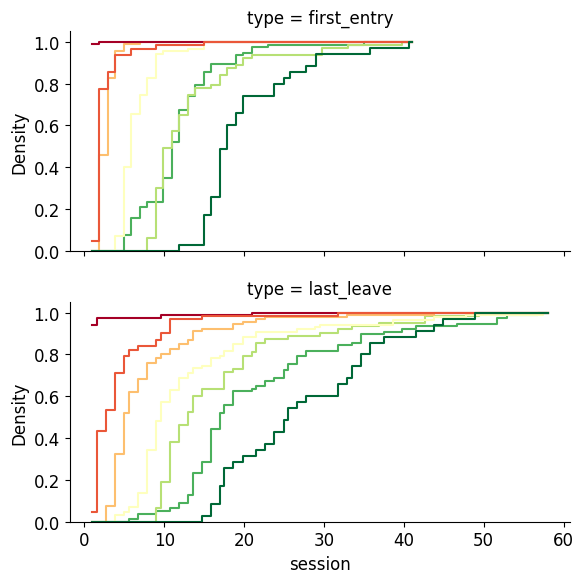

In [108]:
# Set up the FacetGrid for vertical subplots
g = sns.FacetGrid(
    df_stats_this_curriculum,
    col="type",
    col_order=["first_entry", "last_leave"],
    col_wrap=1,
    height=3,
    aspect=2,
    sharex=True,
    sharey=True,
)

# Map the histogram to the FacetGrid
g.map_dataframe(
    sns.histplot,
    x="session",
    hue="current_stage_actual",
    palette=stage_color_mapper,
    element="step",
    fill=False,
    cumulative=True,
    bins=100,
    stat="density",
    common_norm=False,
    legend=True,
)

# Adjust layout
plt.tight_layout()
plt.show()